<a href="https://colab.research.google.com/github/dipakexe/FINAL_YEAR_PROJECT_2023/blob/main/notebooks/lungs_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lungs Disease Detection 🫁**

**INDEX**

- [DATA COLLECTION](#data-collection)
- [DATA PRE-PROCESSING](#data-pre-processing)
- [MODEL BUILDING](#model-building)
- [MODEL EVALUATION](#model-evaluation)
- [CONCLUSION](#conclusion)

### IMPORTING REQUIRED LIBRARIES

In [57]:
import warnings
warnings.filterwarnings("ignore")

# FOR DATA MANIPULATION AND VISUALIZATION
import numpy as np
import matplotlib.pyplot as plt

# FOR MODEL BUILDING
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

# FOR MODEL EVALUATION
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

<a name="data-collection"></a>
## **DATA COLLECTION**

## DATA SOURCE

We're considering two datasets to use to achieve our goal. We can use either one of them or both as required. Anyone can find these datasets on Kaggle. These datasets have pictures with labels showing whether **they're x-rays of lungs with pneumonia or normal lungs.**

1. [Lungs Disease Dataset (4 types) - Chest X-Rays of Viral Pneumonia, Bacterial Pneumonia, Covid and Tuberculosis](https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types).
2. [Chest X-ray Images - for pneumonia detection with deep learning](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)

Currently, we are utilizing the second option, focusing solely on **two image classes: normal X-rays and those depicting pneumonia**. The first option can also serve our purpose by excluding any additional image classes.

## DOWNLOADING THE DATA FROM KAGGLE

In [2]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
os.environ['KAGGLE_CONFIG_DIR'] = os.path.dirname('/content/drive/MyDrive/Colab Notebooks/kaggle.json')

Mounted at /content/drive


In [3]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 99% 1.17G/1.17G [00:13<00:00, 93.1MB/s]
100% 1.17G/1.17G [00:13<00:00, 95.0MB/s]


In [4]:
!mkdir -p data/extracted_data/
!unzip -qn /content/labeled-chest-xray-images.zip -d data/extracted_data/

In [11]:
def files_and_dirs_count(directory):
    return sum(len(files) for _, _, files in os.walk(directory)), sum(len(dirs) for _, dirs, _ in os.walk(directory))

def list_dirs(dirpath="data/extracted_data/", level=0):
    for dir in os.listdir(dirpath):
        dir_full_path = os.path.join(dirpath, dir)
        if os.path.isdir(dir_full_path):
            file_count, dir_count = files_and_dirs_count(dir_full_path)
            indentation = ' |--' * level

            print(f"{indentation}{dir} ({file_count} files and {dir_count} subdirectories)")
            if dir_count > 0:
                list_dirs(dir_full_path, level=level+1)

list_dirs()


chest_xray (5856 files and 6 subdirectories)
 |--test (624 files and 2 subdirectories)
 |-- |--NORMAL (234 files and 0 subdirectories)
 |-- |--PNEUMONIA (390 files and 0 subdirectories)
 |--train (5232 files and 2 subdirectories)
 |-- |--NORMAL (1349 files and 0 subdirectories)
 |-- |--PNEUMONIA (3883 files and 0 subdirectories)


<a name="data-pre-processing"></a>
## **DATA PRE-PROCESSING**

### LOADING THE DATASET

In [38]:
img_size = (224, 224)
batch_size = 64

In [39]:
extracted_dataset_path = "data/extracted_data/chest_xray/"

train_dir = os.path.join(extracted_dataset_path, 'train')
val_dir = os.path.join(extracted_dataset_path, 'val')
test_dir = os.path.join(extracted_dataset_path, 'test')

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50.0,
    horizontal_flip=True,
    validation_split=0.4
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.4)
test_datagen = ImageDataGenerator(rescale=1./255)

In [41]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 3140 images belonging to 2 classes.
Found 2092 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


<a name='model-building'></a>
## **MODEL BUILDING**

In [42]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [58]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [59]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [60]:
checkpoint = ModelCheckpoint('lung_disease_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

In [61]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5, # 5 iterations are enough for transfer learning
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/5
49/49 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9392
Epoch 1: val_accuracy improved from -inf to 0.97461, saving model to lung_disease_model.h5
49/49 [==============================] - 227s 2s/step - loss: 0.1609 - accuracy: 0.9392 - val_loss: 0.0646 - val_accuracy: 0.9746 - lr: 1.0000e-04
Epoch 2/5
49/49 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9542
Epoch 2: val_accuracy improved from 0.97461 to 0.98340, saving model to lung_disease_model.h5
49/49 [==============================] - 133s 3s/step - loss: 0.1052 - accuracy: 0.9542 - val_loss: 0.0399 - val_accuracy: 0.9834 - lr: 1.0000e-04
Epoch 3/5
49/49 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9707
Epoch 3: val_accuracy did not improve from 0.98340
49/49 [==============================] - 111s 2s/step - loss: 0.0776 - accuracy: 0.9707 - val_loss: 0.2337 - val_accuracy: 0.9131 - lr: 1.0000e-04
Epoch 4/5
49/49 [===========================

<a name='model-evaluation'></a>
## **MODEL EVALUATION**

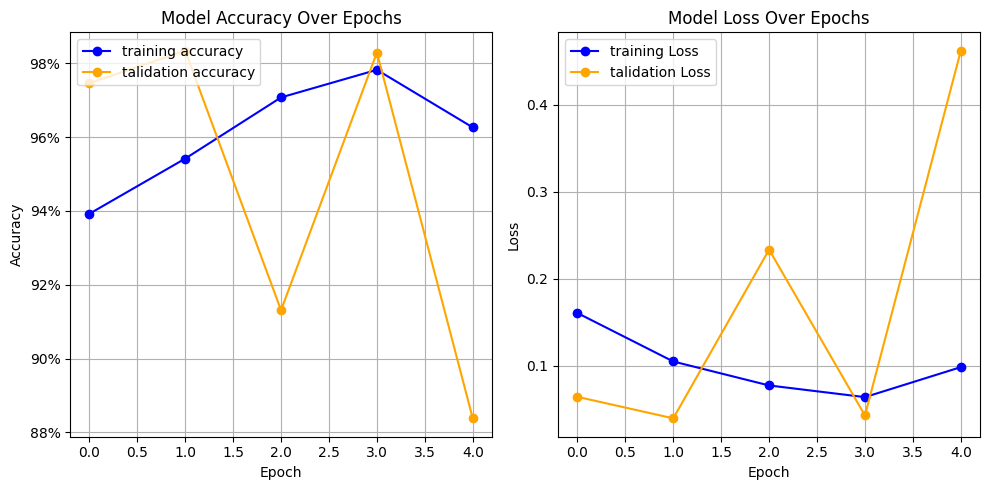

In [62]:
# Plotting the learning curves
plt.figure(figsize=(10, 5))

# The training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='talidation accuracy', color='orange', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid(True)

# The training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='talidation Loss', color='orange', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### ACCURACY ON TEST SET

In [64]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)
print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')

Accuracy on test set: 90.45%


<a name='conclusion'></a>
## **CONCLUSION**

The model has demonstrated performance in line with expectations, achieving training and testing accuracies as compared to other model architectures. As part of our ongoing efforts, we are saving the model weights for future applications.

In [65]:
model.save(os.path.dirname('/content/drive/MyDrive/Colab Notebooks/models/FINAL_YEAR_PROJECT_2023/lung_disease_model.keras'))